# Audio Exploration: Characteristics, Distribution, Frequency and Spectrograms:

In [1]:
import librosa
from librosa.display import waveshow, specshow, cmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path, PurePath
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = Path("./dataset/batches")

In [3]:
# random files for research
def get_samples_path(data_directory, n_samples):
    if n_samples == 1:
        return [Path(data_directory, file) for file in np.random.choice(os.listdir(data_directory), n_samples)][0]
    return [Path(data_directory, file) for file in np.random.choice(os.listdir(data_directory), n_samples)]

In [4]:
# get random files for exploration
sample_paths = get_samples_path(data_directory = DATA_DIR, n_samples = 300)

In [15]:
def get_audio_stats(audio_paths):
    audio_stats = []
    for audio in audio_paths:
        signal, sr = librosa.load(audio, sr = None, mono = False)
        # Channel determination
        channels = "stereo" if len(signal.shape) > 1 and signal.shape[0] == 2 else "mono"
        duration = librosa.get_duration(y=signal, sr = sr)
        mean_amplitude = np.mean(np.abs(signal))
        median_amplitude = np.median(np.abs(signal))
        std_amplitude = np.std(signal)
        # Root-Mean-Square-Energy
        rmse = np.mean(librosa.feature.rms(y=signal))
        # Average Zero crossing rate
        zcr = np.mean(librosa.zero_crossings(y=signal, pad = False)) / len(signal)
        
        audio_stats.append( 
            { "file_name": audio.parts[-1],
              "sample_rate" : sr,
              "duration": duration,
              "channels": channels,
              "root_mean_square_energy": rmse,
              "zero_crossing_rate_avg": zcr,
              "mean_amplitude": mean_amplitude,
              "median_amplitude": median_amplitude,
              "std_amplitude": std_amplitude})
    
    return pd.DataFrame(audio_stats)

In [16]:
stats = get_audio_stats(sample_paths)

In [17]:
stats.head()

,file_name,sample_rate,duration,channels,root_mean_square_energy,zero_crossing_rate_avg,mean_amplitude,median_amplitude,std_amplitude
0,oN8q7p57nZw_segment_46.wav,44100,120.0,stereo,0.192511,0.002937,0.158222,0.135529,0.196701
1,ONFCdOEFuqc_segment_21.wav,44100,120.0,stereo,0.245011,0.004319,0.198612,0.168243,0.248032
2,oN8q7p57nZw_segment_29.wav,44100,120.0,stereo,0.187001,0.003081,0.153634,0.132996,0.189933
3,8vMaujCvPHg_segment_15.wav,44100,120.0,stereo,0.202687,0.002735,0.167636,0.147186,0.205557
4,oN8q7p57nZw_segment_20.wav,44100,120.0,stereo,0.177527,0.003120,0.145584,0.124023,0.181622


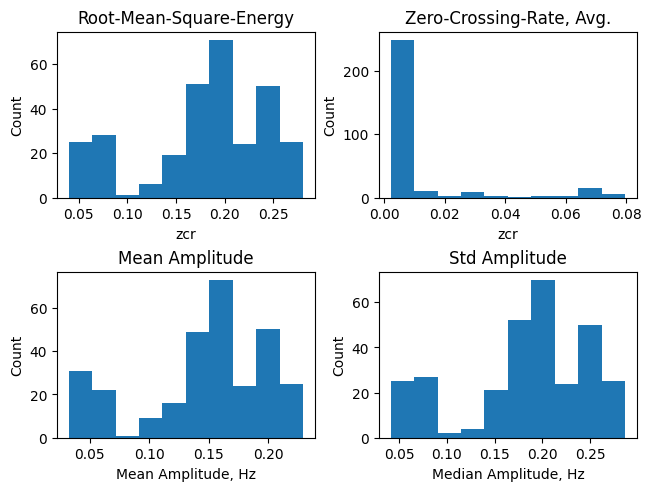

In [24]:
fig, ax = plt.subplots(2, 2, constrained_layout = True)

plt.subplot(2, 2, 1) 
plt.hist(stats.root_mean_square_energy)
plt.title("Root-Mean-Square-Energy")
plt.ylabel("Count")
plt.xlabel("zcr")

plt.subplot(2, 2, 2) 
plt.hist(stats.zero_crossing_rate_avg)
plt.title("Zero-Crossing-Rate, Avg.")
plt.ylabel("Count")
plt.xlabel("zcr")


plt.subplot(2, 2, 3) 
plt.hist(stats.mean_amplitude)
plt.title("Mean Amplitude")
plt.ylabel("Count")
plt.xlabel("Mean Amplitude, Hz")

plt.subplot(2, 2, 4) 
plt.hist(stats.std_amplitude)
plt.title("Std Amplitude")
plt.ylabel("Count")
plt.xlabel("Median Amplitude, Hz")
plt.show();


 If all the files are from a very similar environment (so we have), it does make sense that the statistics across the audio samples would be quite consistent. This is especially true if the driving conditions, vehicle, and recording equipment were roughly the same across all recordings. **But nevertheless it is the strangest pattern in data in my experience lol, especially working with audio files.
 
FYI: it's essential to be aware that while this consistency can be beneficial for training a model (**as it reduces variability**), it's crucial to ensure that the model generalizes well to other environments or variations when deploying in real-world scenarios...


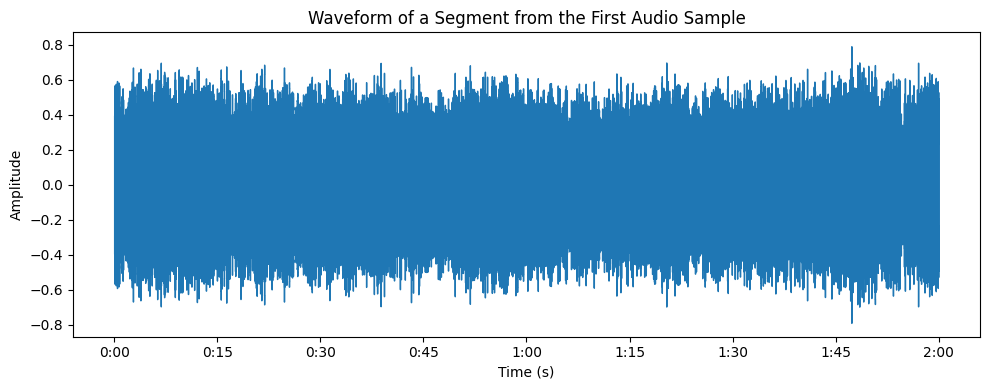

In [11]:
signal, sr = librosa.load(sample_paths[2], sr = None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform of a Segment from the First Audio Sample")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

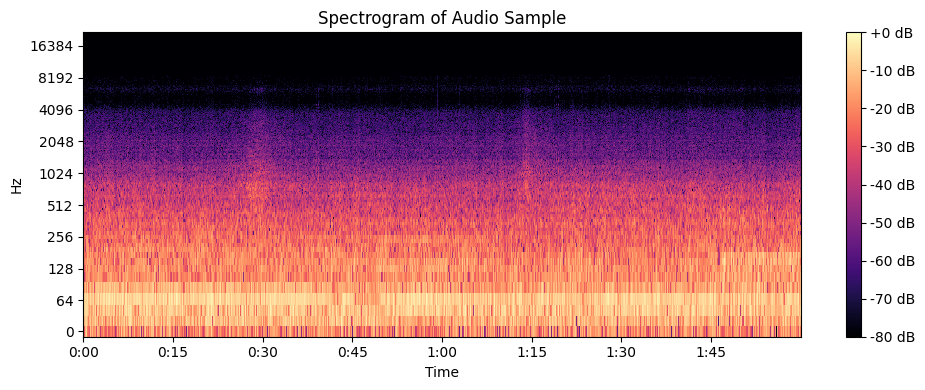

In [12]:
# Plot the spectrogram
D = librosa.amplitude_to_db(librosa.stft(signal), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of Audio Sample')
plt.tight_layout()
plt.show()

### Preprocessing (draft):

* Convert stereo to mono (in any case)
* Normalize the audio volume levels
* Extract real and imaginary spectrograms for each audio file

In [124]:
def preprocess_audio(audio_path):
    """
    Preprocessing of an audio file:
    - Converts stereo to mono
    - Normalize the volume
    - Extract the real and imaginary spectrograms
    
    :param audio_path: the path to the audio file to read 
    :return: 
        - Real part of the spectrogram
        - Imaginary part of the spectrogram
    """
    # load audio
    y, sr = librosa.load(audio_path, sr = None, mono = True)
    # Normalize 
    y = y / np.max(np.abs(y))
    # Compute STFT to get the complex spectrogram
    complex_spectrogram = librosa.stft(y)
    
    # Split the complex spectrogram into real and imaginary parts
    real_spectrogram = np.real(complex_spectrogram)
    imag_spectrogram = np.imag(complex_spectrogram)
    
    return sr, real_spectrogram, imag_spectrogram

In [125]:
sr, real, imag = preprocess_audio(sample_paths[0])

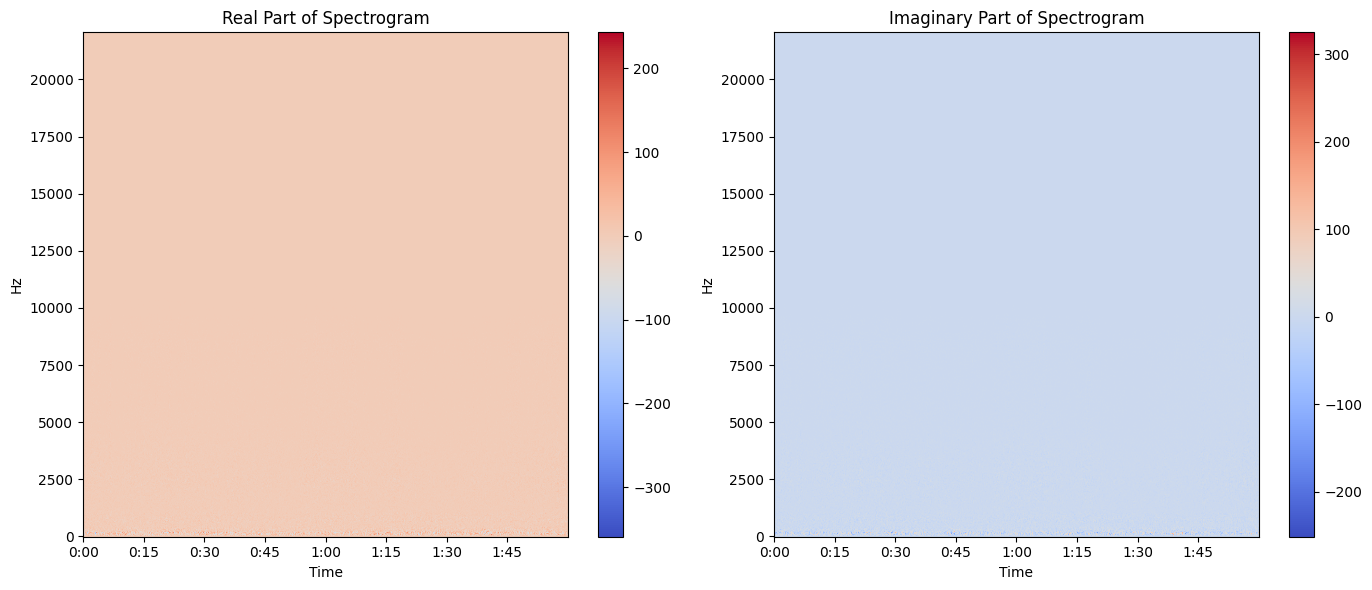

In [127]:
# Display the real and imaginary spectrogram for the first audio sample
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

librosa.display.specshow(real, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title("Real Part of Spectrogram")

plt.subplot(1, 2, 2)

librosa.display.specshow(imag, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.title("Imaginary Part of Spectrogram")
plt.tight_layout()

plt.show()

In [129]:
# Preprocessing class for module 
class AudioPreprocessor:
    def __init__(self, sample_rate=44100):
        self.sample_rate = sample_rate
        
    def preprocess(self, audio_path):
        y, sr = librosa.load(audio_path, sr = self.sample_rate, mono = True)
        y = y / np.max(np.abs(y))
        complex_spectrogram = librosa.stft(y)
        real_spectrogram, imag_spectrogram = np.real(complex_spectrogram), np.imag(complex_spectrogram)
        return y, sr, real_spectrogram, imag_spectrogram

# Model's architecture: Deep Concolutional Neural Network:

In [165]:
import torch.nn as nn
from torch.nn import functional as F

class DeepCRN(torch.nn.Module):
    def __init__(self):
        super(DeepCRN, self).__init__()
        # Convolution layers
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        
        # LSTM layers
        self.lstm1 = torch.nn.LSTM(320, 64, 2, batch_first=True)
        self.lstm2 = torch.nn.LSTM(64, 64, 2, batch_first=True)
        
        # Deconvolution layers
        self.deconv1 = torch.nn.ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv2 = torch.nn.ConvTranspose2d(128, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv3 = torch.nn.ConvTranspose2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        self.deconv4 = torch.nn.ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        
    def forward(self, x):
        # Convolution layers
        x1 = self.pool(F.relu(self.conv1(x)))
        x2 = self.pool(F.relu(self.conv2(x1)))
        x3 = self.pool(F.relu(self.conv3(x2)))
        x4 = self.pool(F.relu(self.conv4(x3)))
        
        # Reshaping for LSTM layers
        x_lstm = x4.view(x4.size(0), x4.size(1) * x4.size(2), x4.size(3))
        
        # LSTM layers
        x_lstm, _ = self.lstm1(x_lstm)
        x_lstm, _ = self.lstm2(x_lstm)
        
        # Reshaping back for deconvolution layers
        x_lstm = x_lstm.view(x_lstm.size(0), 128, 8, x_lstm.size(2))
        
        # Deconvolution layers
        x_d1 = F.interpolate(F.relu(self.deconv1(x_lstm)), scale_factor=2)
        x_d2 = F.interpolate(F.relu(self.deconv2(torch.cat((x_d1, x3), 1))), scale_factor=2)
        x_d3 = F.interpolate(F.relu(self.deconv3(torch.cat((x_d2, x2), 1))), scale_factor=2)
        x_d4 = F.interpolate(self.deconv4(torch.cat((x_d3, x1), 1)), scale_factor=2)
        
        return x_d4

# TODO: Draft architecture not tested (probably wrong skip connections)

In [167]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_instance = DeepCRN()
summary(model_instance, (1, 128, 87))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [Conv2d: 1-1, MaxPool2d: 1-2, Conv2d: 1-3, MaxPool2d: 1-4, Conv2d: 1-5, MaxPool2d: 1-6, Conv2d: 1-7, MaxPool2d: 1-8]

In [164]:
model_instance.parameters

<bound method Module.parameters of DeepCRN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (lstm1): LSTM(32, 32, batch_first=True)
  (lstm2): LSTM(32, 64, batch_first=True)
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv3): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (deconv4): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=128, out_features=32, bias=True)
)>